In [1]:
# Install & import the needed libraries

!pip install -q transformers torch

!pip install triton torchao

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.3/188.3 MB 5.2 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn.functional as F
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import os
os.environ["TQDM_DISABLE"] = "1" # Disables progress bar widgets error caused by GPT

In [3]:
# Load tokenizer & model

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")
model.eval()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [12]:
# Enter your own input text

text = input("Enter a sentence: ")


Enter a sentence: The penguin walks to the mountain


In [13]:
# The tokenization step typically creates subword tokens, and not necessarily whole words

tokens = tokenizer.encode(text, return_tensors="pt")

print("Token IDs:", tokens.tolist()[0])
print("Tokens:")
for tid in tokens[0]:
    print(f"{tid.item():>6} → '{tokenizer.decode(tid)}'")

Token IDs: [464, 38373, 259, 11114, 284, 262, 8598]
Tokens:
   464 → 'The'
 38373 → ' pengu'
   259 → 'in'
 11114 → ' walks'
   284 → ' to'
   262 → ' the'
  8598 → ' mountain'


In [14]:
# The embeddings

with torch.no_grad():
    # Token embeddings
    token_embeds = model.transformer.wte(tokens)

    # Positional embeddings
    positions = torch.arange(tokens.size(1)).unsqueeze(0)
    pos_embeds = model.transformer.wpe(positions)

    embeddings = token_embeds + pos_embeds

# (batch_size, sequence_length, embedding_dim)
print("Embedding shape:", embeddings.shape)

Embedding shape: torch.Size([1, 7, 768])


In [15]:
# The transformer forward pass ensures that each token now contains contextual information from previous tokens.
# This is the most important step conceptually, because this is where the model goes from isolated words to understanding a sentence.

with torch.no_grad():

    # Send the embedding vectors through all transformer layers (for GPT-2, it is 12 layers)
    outputs = model.transformer(inputs_embeds=embeddings)

    # Each layer, applies the self-attention mechanism and goes through a feed-forward NN
    hidden_states = outputs.last_hidden_state

print("Hidden state shape:", hidden_states.shape)

Hidden state shape: torch.Size([1, 7, 768])


In [16]:
# Logits for the next token. This gives one score per vocabulary token (~50k tokens)

with torch.no_grad():
    last_hidden = hidden_states[:, -1, :]
    logits = model.lm_head(last_hidden)

print("Logits shape:", logits.shape)

Logits shape: torch.Size([1, 50257])


In [17]:
# Softmax → probabilities: this is the actual probability distribution the model uses

probs = F.softmax(logits, dim=-1)

top_probs, top_ids = torch.topk(probs, k=10)

print("Top 10 next-token probabilities:")
for p, tid in zip(top_probs[0], top_ids[0]):
    token = tokenizer.decode(tid)
    print(f"{token!r:>12} : {p.item():.4f}")

Top 10 next-token probabilities:
         '.' : 0.2915
         ',' : 0.1955
      ' and' : 0.1346
       ' in' : 0.0368
        '\n' : 0.0287
       ' to' : 0.0245
     ' with' : 0.0185
        "'s" : 0.0169
       ' on' : 0.0150
      ' for' : 0.0108


In [18]:
# Sampling (temperature + top-k)

#    temperature = 0.2 (Set a low temperature value to generate predictable responses)
#    temperature = 1.5 (Set a high temperature value to generate more random and creative responses)
#    top_k = None (full distribution)

def sample_next_token(logits, temperature=1.2, top_k=50):
    logits = logits / temperature

    if top_k is not None:
        values, indices = torch.topk(logits, top_k)
        probs = F.softmax(values, dim=-1)
        choice = torch.multinomial(probs, 1)
        return indices[0, choice]
    else:
        probs = F.softmax(logits, dim=-1)
        return torch.multinomial(probs, 1)

next_token_id = sample_next_token(logits, temperature=0.8, top_k=40)
print("Sampled token:", tokenizer.decode(next_token_id[0]))

Sampled token:  and


In [21]:
# Full loop (generate multiple tokens)

def generate_step_by_step(prompt, steps=20):
    tokens = tokenizer.encode(prompt, return_tensors="pt")

    for _ in range(steps):
        with torch.no_grad():
            outputs = model(tokens)
            logits = outputs.logits[:, -1, :]
            next_token = sample_next_token(logits, temperature=0.1, top_k=40)

        tokens = torch.cat([tokens, next_token], dim=1)
        print(tokenizer.decode(tokens[0]))

generate_step_by_step(text, steps=20)

The penguin walks to the mountain and
The penguin walks to the mountain and looks
The penguin walks to the mountain and looks down
The penguin walks to the mountain and looks down at
The penguin walks to the mountain and looks down at the
The penguin walks to the mountain and looks down at the ground
The penguin walks to the mountain and looks down at the ground.
The penguin walks to the mountain and looks down at the ground.

The penguin walks to the mountain and looks down at the ground.


The penguin walks to the mountain and looks down at the ground.

"
The penguin walks to the mountain and looks down at the ground.

"I
The penguin walks to the mountain and looks down at the ground.

"I'm
The penguin walks to the mountain and looks down at the ground.

"I'm not
The penguin walks to the mountain and looks down at the ground.

"I'm not sure
The penguin walks to the mountain and looks down at the ground.

"I'm not sure if
The penguin walks to the mountain and looks down at the ground.

# GPT-2 Model Experiments


Prompt: Enter a sentence: The penguin walks to the mountain


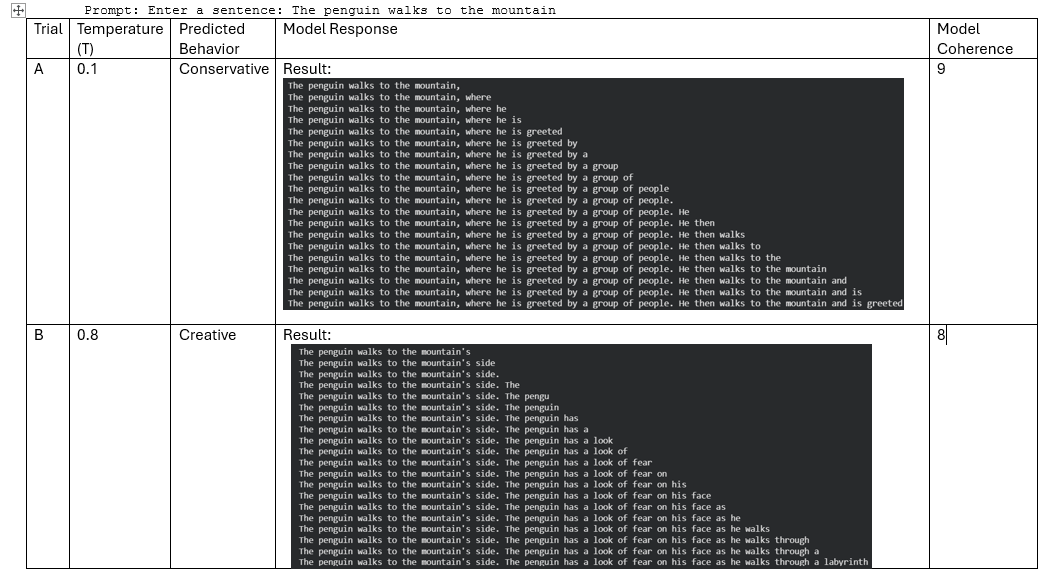

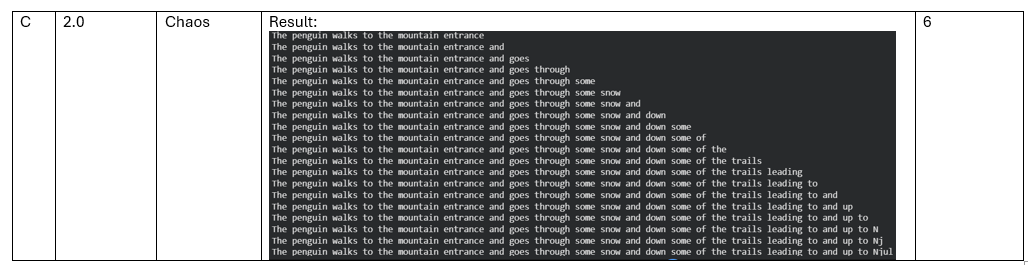

# Analysis

Did your model repeat any words or phrases?


Answer: In experiment A it seemed like it was about to repeat the same phrase. This is expected due to the temperature. When the temperature was 2, in Experiment C the model started outputting random characters at the end, “Njul”.

Did the model use real words, or did it start outputting random characters and punctuation? Explain how the "Probability Distribution" changed to allow this.

Answer: The model used real words with an exception for the last word in Experiment C. This may be due to how the probability distribution changed. When the temperature is low, for example in Experiment A, it allows for the LLM to choose the token with the highest probability as the next output. In experiment B, with a medium temperature, other tokens have a chance of being chosen instead of the one with the highest probability. In experiment C, with high temperature, any token could be chosen as the next output, making the output become somewhat incoherent.

If you were building a medical AI to give prescriptions or advice, which temperature would you use?

Answer:I would use 0.1 temperature as giving prescription or advice would need to be accurate, therefore there is no need for any creativity or unlikely tokens being selected. A conservative behaviour would therefore be ideal.

If you were building an AI to write a surrealist dream-journal, which would you use?

Answer: I would use 0.8 for its creative behaviour. The model response based on my prompt gave a perfect example of why it would be the best to use.